In [1]:
import mitsuba as mi

mi.set_variant("cuda_ad_rgb")
import drjit as dr
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.rough_scene import (
    ENVLIGHT_KEY,
    ROUGH_KEY,
    Scene,
    generate_rand_envlight,
    generate_rand_init_values,
    generate_rand_rough_tex,
    plot_rough_envlight,
    plot_rough_envlight2,
    reset_scene,
    reset_func,
    get_full_zeros_params,
    get_full_ones_params,
    run_opt_set_init,
    plot_opt_results,
    upsample,
)
from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS
from utils.plot import (
    plot_loss_linear_interp_1d,
    plot_loss_bilinear_interp_2d,
    plot_losses,
)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

# Reference scenes rendering

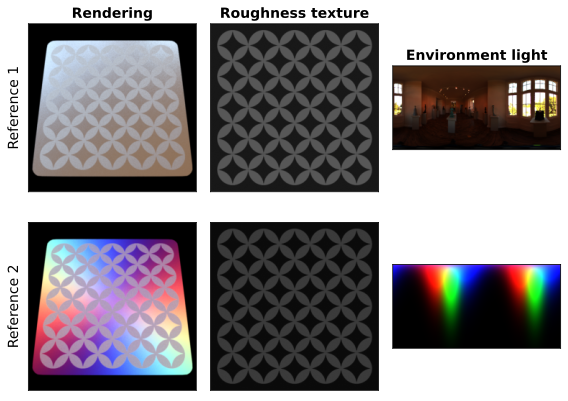

In [2]:
scene_ref = {k: reset_scene(k) for k in Scene}
params = {k: mi.traverse(scene_ref[k]) for k in Scene}

# Render reference images
image_ref = {k: mi.render(scene_ref[k], seed=0, spp=128) for k in Scene}
params_rough_ref = {k: params[k][ROUGH_KEY] for k in Scene}
params_envlight_ref = {k: params[k][ENVLIGHT_KEY] for k in Scene}

image_ref_bm = {k: image_to_bm(image_ref[k])  for k in Scene}
params_rough_ref_bm = {k: unidim_to_bm(params_rough_ref[k])  for k in Scene}
params_envlight_ref_bm = {k: unidim_to_bm(params_envlight_ref[k])  for k in Scene}

refs = {k: {
    "img": image_ref_bm[k],
    "params_rough": params_rough_ref_bm[k],
    "params_envlight": params_envlight_ref_bm[k],
} for k in Scene}

def get_ref_params(scene_id):
    return {
        ROUGH_KEY: params_rough_ref[scene_id],
        ENVLIGHT_KEY: params_envlight_ref[scene_id],
    }

# Plot
plot_rough_envlight2({f'Reference {k.value}': (image_ref_bm[k], params_rough_ref_bm[k], params_envlight_ref_bm[k]) for k in Scene})

In [3]:
nb_samples = 2
spp_primal = 32
spp_grad = 4

In [4]:
# get reference losses
scene_s1 = reset_scene(Scene.COND1)
image_s1 = mi.render(scene_s1, mi.traverse(scene_s1), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss_s1 = {k: to_float(LOSS_FNS[k](image_s1, image_ref[Scene.COND1])) for k in LOSS_FNS}

scene_s2 = reset_scene(Scene.COND2)
image_s2 = mi.render(scene_s2, mi.traverse(scene_s2), seed=0, spp=spp_primal, spp_grad=spp_grad)
ref_loss_s2 = {k: to_float(LOSS_FNS[k](image_s2, image_ref[Scene.COND2])) for k in LOSS_FNS}

In [5]:
def run_opt_set_init(
    scene_name: Scene,
    init_values,
    optimizer_name="adam",
    lr=1e-2,
    loss_fn=mse,
    n_iterations=10,
    spp=16
):
    # Optimization parameters
    spp_primal = spp
    spp_grad = 4
    optimizer_name = optimizer_name.lower().strip()

    losses = []
    image_bm_init = []
    image_bm_end = []
    tex_bm_init = []
    tex_bm_end = []
    params_end = []

    nb_opt_samples = len(init_values)

    for (opt_sample, initial_values) in enumerate(init_values):
        # Load scene
        scene = reset_scene(scene_name)

        params = mi.traverse(scene)
        params[ROUGH_KEY] = initial_values
        params.update()

        if optimizer_name == "sgd":
            opt = mi.ad.optimizers.SGD(lr=lr)
        elif optimizer_name == "adam":
            opt = mi.ad.optimizers.Adam(lr=lr)
        else:
            raise ValueError(f"Unknown optimizer {optimizer_name}")

        opt[ROUGH_KEY] = params[ROUGH_KEY]
        params.update(opt)

        losses.append([])
        for it in range(1,n_iterations+1):
            image = mi.render(
                scene,
                params,
                seed=it * nb_opt_samples + opt_sample,
                spp=spp_primal,
                spp_grad=spp_grad,
            )

            if it == 1:
                image_bm_init.append(image_to_bm(image))
                tex_bm_init.append(unidim_to_bm(params[ROUGH_KEY]))
            
            # Apply loss function
            loss = loss_fn(image, image_ref[scene_name])

            # Backpropagate
            dr.backward(loss)

            # Optimizer: take a gradient step
            opt.step()
            opt[ROUGH_KEY] = dr.clamp(opt[ROUGH_KEY], 1e-2, 1.0)

            # Optimizer: Update the scene parameters
            params.update(opt)

            if it == n_iterations:
                image_bm_end.append(image_to_bm(image))
                tex_bm_end.append(unidim_to_bm(params[ROUGH_KEY]))
                params_end.append(params[ROUGH_KEY])

            print(
                f"[Sample {opt_sample+1}/{nb_opt_samples}]  Iteration {it:03d}: loss={loss[0]:.5f}",
                end="\r",
            )
            losses[opt_sample].append(loss[0])
        print()
        
    return {
        "losses": losses,
        "image_bm_init": image_bm_init,
        "image_bm_end": image_bm_end,
        "tex_bm_init": tex_bm_init,
        "tex_bm_end": tex_bm_end,
        "params_end": params_end,
    }


# By hand

In [6]:
def cross_pair(a, b, cross_rate=0.5):
    nb_cross = int(cross_rate * a.shape[0])
    cross_points = list(np.random.choice(a.shape[0], nb_cross, replace=False))
    a, b = np.array(a), np.array(b)
    a[cross_points, ...], b[cross_points, ...] = b[cross_points, ...], a[cross_points, ...]
    return mi.TensorXf(a), mi.TensorXf(b)

def mutate(a, mut_rate=0.1):
    if isinstance(a, dict):
        return {key: mutate(val, mut_rate) for (key, val) in a.items()}
    else:
        return mi.TensorXf(np.clip(np.array(a) + np.random.normal(0, mut_rate, a.shape), 0, 1))

In [7]:
def ga_opt(pop_size = 10, selection_rate=0.3, mut_rate=0.03, nb_gen = 10, nb_grad_iter = 10, spp=32):
    best_image_gen = []
    best_tex_gen = []

    values = [generate_rand_rough_tex(Scene.COND1, seed=i) for i in range(pop_size)]
    for gen in range(nb_gen):
        print(f"Generation {gen+1}/{nb_gen}")
        res = run_opt_set_init(Scene.COND1, values, optimizer_name="adam", lr=1e-2, loss_fn=mse, n_iterations=nb_grad_iter, spp=spp)
        # handmade genetic algorithm to select the best samples for the next generation
        
        losses = np.array(res["losses"])[:,-1]
        images = res["image_bm_end"]
        params_list = res["tex_bm_end"]
        values = res["params_end"]
        idx = np.argsort(losses)

        best_image_gen.append(image_to_bm(images[idx[0]]))
        best_tex_gen.append(unidim_to_bm(values[idx[0]]))

        # select the best samples for the next generation and cross them + mutate them
        best_values = [values[i] for i in idx[:max(int(pop_size*selection_rate), 1)]]
        new_values = []
        for i in range(pop_size):
            a = best_values[np.random.randint(len(best_values))]
            b = best_values[np.random.randint(len(best_values))]
            a, b = cross_pair(a, b)
            a = mutate(a, mut_rate)
            new_values.append(a)
        values = new_values
    
    return best_image_gen, best_tex_gen

In [8]:
def plot(
    images_bm, tex_bm, size_factor=3
):
    fig, ax = plt.subplots(
        ncols=2,
        nrows=len(images_bm),
        figsize=(8, size_factor * len(images_bm)),
        squeeze=False,
    )
    for i, (img, tex) in enumerate(
        zip(images_bm, tex_bm)
    ):
        ax[i, 0].imshow(img, vmin=0, vmax=1)
        ax[i, 1].imshow(tex, vmin=0, vmax=1)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
    ax[0, 0].set_title("Rendering", weight="bold", size=14)
    ax[0, 1].set_title("Roughness texture", weight="bold", size=14)
    plt.tight_layout()
    plt.show()

In [9]:
pop_size=10
nb_grad_iter=60
nb_gen=3
spp=32

Generation 1/3
[Sample 1/10]  Iteration 060: loss=0.00206
[Sample 2/10]  Iteration 060: loss=0.00204
[Sample 3/10]  Iteration 060: loss=0.00205
[Sample 4/10]  Iteration 060: loss=0.00219
[Sample 5/10]  Iteration 060: loss=0.00206
[Sample 6/10]  Iteration 060: loss=0.00212
[Sample 7/10]  Iteration 060: loss=0.00209
[Sample 8/10]  Iteration 060: loss=0.00204
[Sample 9/10]  Iteration 060: loss=0.00216
[Sample 10/10]  Iteration 060: loss=0.00212
Generation 2/3
[Sample 1/10]  Iteration 060: loss=0.00169
[Sample 2/10]  Iteration 060: loss=0.00177
[Sample 3/10]  Iteration 060: loss=0.00168
[Sample 4/10]  Iteration 060: loss=0.00174
[Sample 5/10]  Iteration 060: loss=0.00177
[Sample 6/10]  Iteration 060: loss=0.00170
[Sample 7/10]  Iteration 060: loss=0.00175
[Sample 8/10]  Iteration 060: loss=0.00172
[Sample 9/10]  Iteration 060: loss=0.00177
[Sample 10/10]  Iteration 060: loss=0.00176
Generation 3/3
[Sample 1/10]  Iteration 060: loss=0.00170
[Sample 2/10]  Iteration 060: loss=0.00169
[Sample

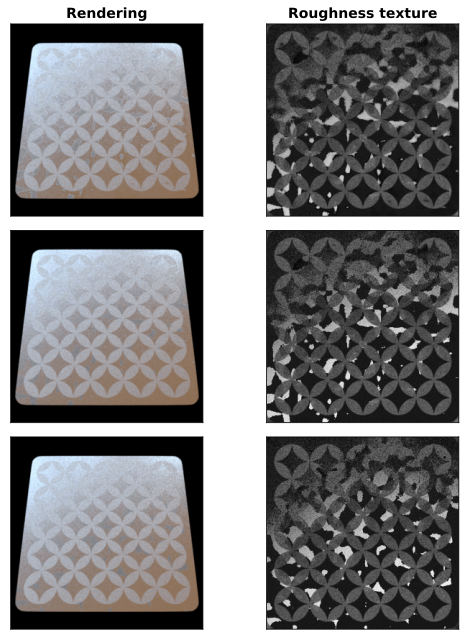

In [10]:
plot(*ga_opt(pop_size=pop_size, nb_grad_iter=nb_grad_iter, nb_gen=nb_gen, spp=spp))

In [11]:
values = [generate_rand_rough_tex(Scene.COND1, seed=i) for i in range(pop_size)]
res = run_opt_set_init(Scene.COND1, values, optimizer_name="adam", lr=1e-2, loss_fn=mse, n_iterations=nb_gen*nb_grad_iter, spp=spp)

[Sample 1/10]  Iteration 180: loss=0.00166
[Sample 2/10]  Iteration 180: loss=0.00163
[Sample 3/10]  Iteration 180: loss=0.00166
[Sample 4/10]  Iteration 180: loss=0.00169
[Sample 5/10]  Iteration 180: loss=0.00167
[Sample 6/10]  Iteration 180: loss=0.00168
[Sample 7/10]  Iteration 180: loss=0.00166
[Sample 8/10]  Iteration 180: loss=0.00166
[Sample 9/10]  Iteration 180: loss=0.00168
[Sample 10/10]  Iteration 180: loss=0.00166


# Sandbox: Global Opt using PyMOO

In [ ]:
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

class TextureOpt(Problem):
    def __init__(self, scene_id, ref_img, tex_shape, loss_fn, spp):
        self.scene_id = scene_id
        self.ref_img = ref_img
        self.loss_fn = loss_fn
        self.spp = spp
        self.shape = tex_shape
        super().__init__(n_var=np.prod(self.shape), n_obj=1, n_constr=0, xl=0.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        nb_samples = x.shape[0]
        out["F"] = np.array([0.0]*nb_samples)
        for i in range(nb_samples):
            scene = reset_scene(self.scene_id)
            params = mi.traverse(scene)
            params[ROUGH_KEY] = mi.TensorXf(self.reshape_params(x[i]))
            params.update()
            image = mi.render(scene, params, seed=i, spp=self.spp)
            loss = to_float(self.loss_fn(image, self.ref_img))
            out["F"][i] = loss
    
    def reshape_params(self, x):
        return x.reshape(self.shape)
    
    def show_res(self, x):
        scene = reset_scene(self.scene_id)
        params = mi.traverse(scene)
        params[ROUGH_KEY] = mi.TensorXf(self.reshape_params(x))
        params.update()
        image = mi.render(scene, params, seed=0, spp=self.spp)
        return image_to_bm(image)


In [67]:
from pymoo.algorithms.soo.nonconvex.ga import GA

res_array = [2, 16, 128]
spp = 32
a = None
pop_size = 10
n_gen = 5

for res in res_array:
    # first run a genetic algorithm to get a good starting point
    if a is None:
        algorithm = GA(pop_size=pop_size, eliminate_duplicates=True)
    else:
        a = np.array(upsample(a, res)).flatten()
        algorithm = GA(pop_size=pop_size, eliminate_duplicates=True, sampling=np.asarray([a.copy() for i in range(pop_size)]))
    problem = TextureOpt(Scene.COND1, image_ref[Scene.COND1], (res,res,1), mse, spp)
    res_ga = minimize(problem, algorithm, ('n_gen', n_gen), seed=0, verbose=True)
    a = problem.reshape_params(res_ga.X.copy())

    # now run the gradient descent
    a = np.array(run_opt_set_init(Scene.COND1, [a], optimizer_name="adam", lr=1e-2, loss_fn=mse, n_iterations=10, spp=spp)[0])

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  0.0179083873 |  0.0108793583
     2 |       20 |  0.0115544654 |  0.0098280227
     3 |       30 |  0.0104980079 |  0.0086513069
     4 |       40 |  0.0094902416 |  0.0075214701
     5 |       50 |  0.0084428632 |  0.0075214701
[Sample 1/1]  Iteration 010: loss=0.00691
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        1 |  0.0094249081 |  0.0094249081
     2 |       11 |  0.0094562743 |  0.0094224801
     3 |       21 |  0.0094350667 |  0.0094048036
     4 |       31 |  0.0094152494 |  0.0093550868
     5 |       41 |  0.0093998724 |  0.0093550868
[Sample 1/1]  Iteration 010: loss=0.00587
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        1 |  0.0058359019 |  0.0058359019
     2 |       11 |  0.0058301980 |  0.0057911626
     3 |       21 |  0.0058188238 |  0.0057911626
     4 |       31 |  0.0058120891 |  0.0057911626
     5 |       41 |  0.0058065929 |  0.0057911626
[Sample 1/1]  It

In [68]:
problem.show_res(np.array(a))

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]